In [1]:
%matplotlib inline

# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

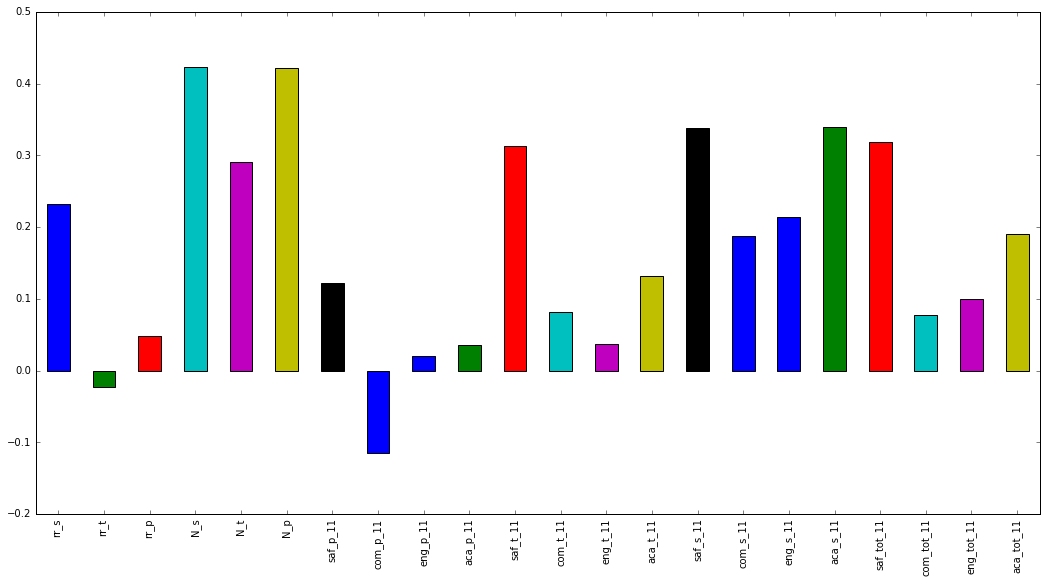

In [21]:
correlations[survey_fields].plot.bar(y="sat_score", figsize=(18, 9))

Data dictionary of `survey_fields`:

| field | Meaning | Corr abs>.25|
| ----- | ------- | ----- |
|rr_s	| Student Response Rate | |
| rr_t |	Teacher Response Rate | |
| rr_p |	Parent Response Rate | |
| N_s |	Number of student respondents | * |
| N_t |	Number of teacher respondents | *  |
| N_p |	Number of parent respondents | * |
| nr_s |	Number of eligible students | |
| nr_t |	Number of eligible teachers | |
| nr_p |	Number of eligible parents | |
| saf_p_11 |	Safety and Respect score based on parent responses | |
| com_p_11 |	Communication score based on parent responses | |
| eng_p_11 |	Engagement score based on parent responses | |
| aca_p_11 |	Academic expectations score based on parent responses | |
| saf_t_11 |	Safety and Respect score based on teacher responses | * |
| com_t_11 |	Communication score based on teacher responses | |
| eng_t_11 |	Engagement score based on teacher responses | |
| aca_t_11 |	Academic expectations score based on teacher responses | |
| saf_s_11 |	Safety and Respect score based on student responses | * |
| com_s_11 |	Communication score based on student responses | |
| eng_s_11 |	Engagement score based on student responses | |
| aca_s_11 |	Academic expectations score based on student responses | *  |
| saf_tot_11 |	Safety and Respect total score | * |
| com_tot_11 |	Communication total score | |
| eng_tot_11 |	Engagement total score | |
| aca_tot_11 |	Academic Expectations total score| |

Interesting findings:
* The response rate didn't seem to matter (one would think response rate could mean engagedness which might lead to overall higher scores), but the total number of resopndants did correlate.
* Safetey and Respect, as judged by both students and teachers, is correlated. 
* Academic expectations as perceived by students is correlated.

## Digging into safety scores

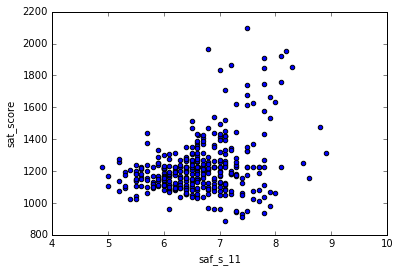

In [23]:
combined.plot(kind="scatter", x="saf_s_11", y="sat_score")

There are a few higher safety rankings and higher SAT scores that seem to be the factor for the correlation. The bulk of the scores and rankings are in a cloud of sorts.

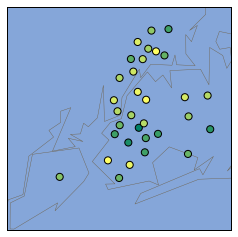

In [25]:
import numpy

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts.lon.tolist()
latitudes = districts.lat.tolist()
m.scatter(x=longitudes, y=latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")


## Racial Differences

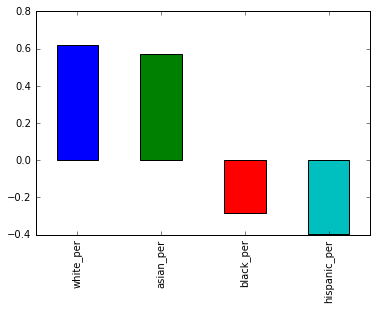

In [28]:
race = ["white_per", "asian_per", "black_per", "hispanic_per"]
correlations[race].plot(kind="bar", y=combined["sat_score"])

There seems to be a strong positive correlation for schools with a higher percentage of white or asian students and higher scores, a weak negative correlation for schools with a higher percentage of black students with lower scores, and a moderate correlation for schools with a higher percentage of hispanic students with lower scores.

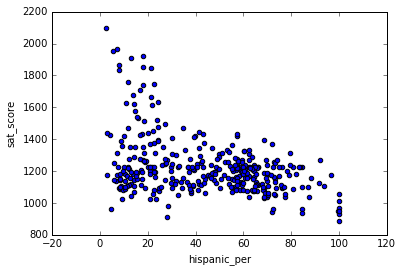

In [29]:
combined.plot(kind="scatter", x="hispanic_per", y="sat_score")

Schools with an average SAT score > 1600 all have < 40% hispanic students, and schools 100% hispanic students all have average SAT scores < 1200. 

In [34]:
hisp_95 = combined[combined.hispanic_per > .95].sort_values('hispanic_per', ascending=False)
hisp_95['SCHOOL NAME']


286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
44                         MANHATTAN BRIDGES HIGH SCHOOL
253                            MULTICULTURAL HIGH SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
81               COMMUNITY HEALTH ACADEMY OF THE HEIGHTS
80                      CITY COLLEGE ACADEMY OF THE ARTS
84     HIGH SCHOOL FOR INTERNATIONAL BUSINESS AND FIN...
358          EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK
209              EL PUENTE ACADEMY FOR PEACE AND JUSTICE
85              HIGH SCHOOL FOR MEDIA AND COMMUNICATIONS
139                KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
179                        HIGH SCHOOL OF WORLD CULTURES
31                 MANHATTAN ACADEMY FOR ARTS & LANGUAGE
86                HIGH SCHOOL F

These schools tend to be international, bilingual, or otherwise inclusive programs.

In [37]:
hisp_10 = combined[(combined.hispanic_per < 10) & (combined.sat_score > 1800)]
hisp_10['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools tend to be elite, magnet, or otherwise high performing special schools

## Gender

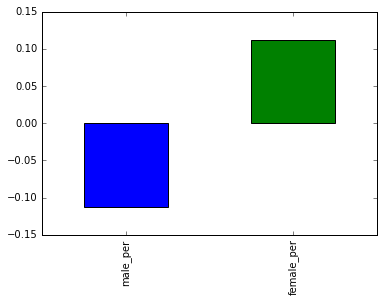

In [40]:
correlations[["male_per", "female_per"]].plot.bar(y="sat_score")

While there are no strong correlations here, there is some level of correlation that schools with a higher percentage of female students has higher scores, and a higher percentage of male students has lower scores.

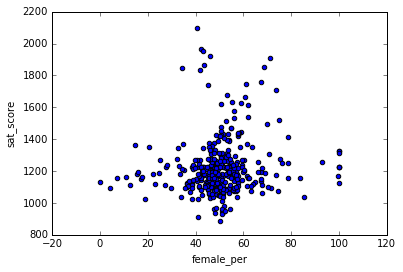

In [41]:
combined.plot(kind="scatter", x="female_per", y="sat_score")

Schools with the highest average SAT scores, anything above about 1500, fall in the range of 40-80% female students. That doesn't really tell much. All girls schools and all boys school both have lower average scores, never getting above 1400 (and all boys schools never getting above 1200). 

In [42]:
fem_60 = combined[(combined.female_per > .6) & (combined.sat_score > 1700)]
fem_60['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools tend to be specialized schools, either at colleges or with rigorous academic programs designed for college prep.

## AP Scores

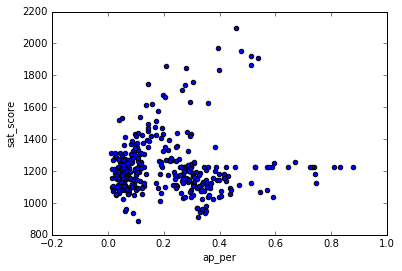

In [44]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot(kind="scatter", x="ap_per", y="sat_score")

There doesn't apppear to be a strong correlation between percentage of AP test takers and average SAT score. The highest scores, >1600, have an AP test take rate from <20% - 50%. Schools with >60% AP test take rate never break an average of 1250 on the SAT scores.

## Class Size

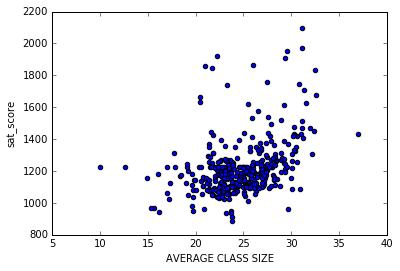

In [51]:
combined.plot(kind="scatter", x="AVERAGE CLASS SIZE", y="sat_score")

In [52]:
combined[combined["AVERAGE CLASS SIZE"] <= 20].sat_score.max()

1315.0

There doesn't seem to be a strong correlation between class size and average sat score. The highest average SAT score for schools with an average class size of 20 or less is 1315. 

### Further work
Later on I would like to figure out which neighborhoods have the best schools, combine this information with a dataset containing property values, and find the least expensive neighborhoods that have good schools.